This script converts monthly preciptation to snow water equivalent (SWE) and then converts SWE to snow density, snow depth, and thermal conductivity. 
See Jafarov et al., (2012) doi:10.5194/tc-6-613-2012 for the references listed in the script.

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

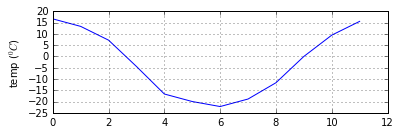

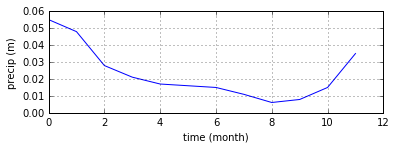

In [2]:
# avearaged monthly tempratures and precip for Fairbanks, AK 
# http://www.usclimatedata.com/climate/fairbanks/alaska/united-states/usak0083

N=12; # number of months
months=np.linspace(1, N, N)
# conver inch precip to meters
prec=0.0254*np.array([0.59, 0.43, 0.24, 0.31, 0.59, 1.38, 2.17, 1.89, 1.1, 0.83, 0.67, 0.63])

t_air_h=np.array([ 1, 10, 25, 44, 61, 72, 73, 66, 55, 32, 11, 5])
t_air_l=np.array([ -17, -13, -3, 21, 38, 49, 52, 46, 35, 17, -6, -13])
t_air=(t_air_l+t_air_h)/2
# temperature converting F to C
t_air=(t_air-32)/1.8

# make it a hydrological year
ta_month=np.zeros(N);
prec_month=np.zeros(N);

x=t_air[0:6] 
ta_month[0:6]=t_air[6:12]
ta_month[6:12]=x

x=prec[0:6]
prec_month[0:6]=prec[6:12]
prec_month[6:12]=x

# check the values 
plt.subplot(211)
plt.plot(ta_month);
plt.ylabel('temp ($^0C$)')
plt.grid(); 
plt.show()
plt.subplot(212)
plt.plot(prec_month);
plt.ylabel('precip (m)')
plt.xlabel('time (month)')
plt.grid(); 
plt.show()

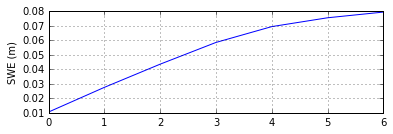

In [3]:
# find indexes for which temp > 0 and make precip = 0
pos_temp_ind=np.array(np.where(ta_month>0))  
prec_month[pos_temp_ind]=0
neg_temp_ind=np.array(np.where(ta_month<=0))  

if not pos_temp_ind.any():  
    # monthly temp is always below zero
    # i.e. it constantly snows over whole year
    # the point associated with glaciaer and needs to excluded 
    print 'snows constatly: stop!' 

m=np.size(neg_temp_ind)
pp=0.5; # assume only 50% of precip change to at the beg and end of the snow season

# this is portions of the code assumes a perfect winter season
# needs to be used with care when there is a warm month during snow season
if (m==1):
    s_idx=neg_temp_ind[:,0]
    e_idx=neg_temp_ind[:,m-1]
    prec_month[s_idx]=prec_month[s_idx]*pp
else:
    s_idx=neg_temp_ind[:,0]
    e_idx=neg_temp_ind[:,m-1]
    prec_month[s_idx]=prec_month[s_idx]*pp
    prec_month[e_idx]=prec_month[e_idx]*pp

#print prec_month[s_idx],prec_month[e_idx]

# sum up precip to get SWE
j=0; s=0; swe=np.zeros(m);
for i in range(s_idx,e_idx+1): 
    s=s+prec_month[i]
    swe[j]=s
    j=j+1
    
# check the SWE values 
plt.subplot(211)
plt.plot(swe);
plt.ylabel('SWE (m)')
plt.grid(); 
plt.show()

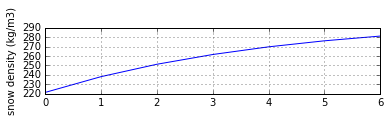

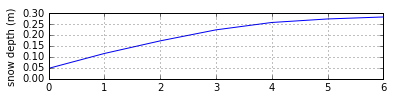

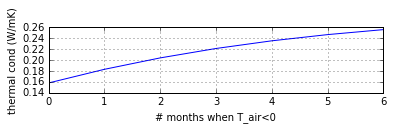

In [4]:
#calculating snow density, depth and thermal counductivity
r_snow=np.zeros(m); # snow density in kg/m3
h_snow=np.zeros(m); # snow depth in m
c_snow=np.zeros(m); # snow depth in W/mK

rho_sn_min=200; rho_sn_max=300 # allowed min and max snow density 
tauf=0.24 # e-folding value (see Verseghy, 1991)

s=rho_sn_min
s=((s - rho_sn_max)*np.exp(-tauf)) + rho_sn_max
r_snow[0] = s
for i in range(1,m): 
    # starting from month 2 tauf should be multpled by the 30 days
    # otherwise snow thermal conductivity can be low and insulate ground well enough over the season
    # usually we assume constant max snow thermal conductivity over snow season
    s=((s - rho_sn_max)*np.exp(-tauf)) + rho_sn_max
    r_snow[i] = s

h_snow  = (swe/(r_snow*0.001)) 
# snow thermal conductivity according to M. Sturm, 1997.
c_snow = (0.138-1.01*r_snow + 3.233*(r_snow**2))*1e-6

# check the values 
plt.subplot(311)
plt.plot(r_snow);
plt.ylabel('snow density (kg/m3)')
plt.grid(); 
plt.show()

plt.subplot(312)
plt.plot(h_snow);
plt.ylabel('snow depth (m)')
plt.grid(); 
plt.show()

plt.subplot(313)
plt.plot(c_snow);
plt.ylabel('thermal cond (W/mK)')
plt.xlabel('# months when T_air<0')
plt.grid(); 
plt.show()
